<a href="https://colab.research.google.com/github/AmandaGamage/cnn_architectures/blob/main/CNN_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ### EEE6503-01: Computer Vision

# Homework \# I: CNN Architectures

**<div style="text-align: right"> Due date: Oct. 11th, 2024. </div>**
**<div style="text-align: right"> Please upload your file @ learnus by 9:00 PM. </div>**
<div style="text-align: right"> Lee Geon(이건): <a href="mailto:geon.lee@yonsei.ac.kr">geon.lee@yonsei.ac.kr</a>
<div style="text-align: right"> Sanghoon Lee(이상훈): <a href="mailto:shoon.lee@yonsei.ac.kr">shoon.lee@yonsei.ac.kr</a> </div>

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.**
4. **Report your results.**

<h2><span style="color:blue">[2023321198] [Gamage Amanda Sheron]</span> </h2>

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-10-10 07:17:56.680768


The objective of this assignment is to train the MobileNetV2, VGGNet, and ResNet models to classify the CIFAR-10 dataset
(Please refer to the papers of [MobileNetV2](https://arxiv.org/abs/1801.04381),
[VGGNet](https://arxiv.org/abs/1409.1556), and
[ResNet](https://arxiv.org/abs/1512.03385)).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import torch.optim as optim
from torch.optim import lr_scheduler

torch.manual_seed(100)
np.random.seed(100)

Step 1: Load the dataset

In [ ]:
import torchvision
import torchvision.transforms as transforms

########## DO NOT modify this code ##########
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1, pin_memory=True)

100%|██████████| 170498071/170498071 [00:10<00:00, 16022372.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Step 2: Build the models

Build the models of MobileNetV2, VGGNet-11, and ResNet-18.

* Build the models without using **torch.nn.Conv2d, torch.nn.functional.conv2d, torch.nn.ReLU, torch.nn.functional.relu, torch.nn.ReLU6, torch.nn.functional.relu6, torch.nn.Linear, torch.nn.functional.linear, torch.nn.BatchNorm2d**, or **torch.nn.functional.batch_norm**.

* Build the MobileNetV2, VGGNet-11, and ResNet-18 models following the configurations specified in [MobileNetV2](https://pytorch.org/vision/stable/_modules/torchvision/models/mobilenetv2.html), [VGGNet-11](https://pytorch.org/vision/0.8/_modules/torchvision/models/vgg.html#vgg11), and [ResNet-18](https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html#resnet18), respectively
(Note that the output size of the final layer should be set to 10).

* You are free to adjust the number of channels and layers in models as needed.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You may use modules intended to initialize parameters, e.g., torch.nn.init.xavier_normal_
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size

        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        batch_size, in_channels, height, width = x.shape

        # Manually add padding to ensure size consistency
        if self.padding > 0:
            x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Unfold operation
        x_unf = nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        weight_reshaped = self.weight.view(self.weight.size(0), -1)

        # Calculate the output using matrix multiplication
        out = torch.einsum('bkn,ok->bon', x_unf, weight_reshaped) + self.bias.unsqueeze(1)

        # Calculate output height and width based on stride and padding
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1

        return out.view(batch_size, weight_reshaped.size(0), out_height, out_width)

class DepthwiseConv(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseConv, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(in_channels, 1, kernel_size, kernel_size))  # (in_channels, 1, k, k)
        self.bias = nn.Parameter(torch.randn(in_channels))

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()

        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        x_unf = nn.functional.unfold(x, kernel_size=self.kernel_size, padding=0, stride=self.stride)
        x_unf = x_unf.view(batch_size, in_channels, self.kernel_size**2, -1)

        weight_reshaped = self.weight.view(in_channels, -1).to(x.device)

        out = torch.einsum('bikn,ik->bin', x_unf, weight_reshaped) + self.bias.view(1, -1, 1)

        # Reshape to get the output in the correct spatial dimensions
        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_dconv=out.view(batch_size, in_channels, out_height, out_width)
        return out_dconv

class ReLU(nn.Module):
    def forward(self, x):
        return torch.max(x, torch.tensor(0.0))

class ReLU6(nn.Module):
    def forward(self, x):
        return torch.clamp(x, 0, 6)

class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        linear_layer=torch.matmul(x, self.weight.T) + self.bias
        return linear_layer


class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
      if self.training:
        mean = x.mean([0, 2, 3], keepdim=True)
        var = x.var([0, 2, 3], keepdim=True)

        # Update running stats
        self.running_mean = ((1 - self.momentum) * self.running_mean + self.momentum * mean.squeeze())
        self.running_var = ((1 - self.momentum) * self.running_var + self.momentum * var.squeeze())
      else:
        mean = self.running_mean.view(1, -1, 1, 1)
        var = self.running_var.view(1, -1, 1, 1)


      x_normalized = (x - mean) / (var + self.eps).sqrt()
      return self.gamma.view(1, -1, 1, 1) * x_normalized + self.beta.view(1, -1, 1, 1)

# MobileNetV2

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super(MobileNetV2, self).__init__()


        inverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(32 * width_mult)
        last_channel = int(1280 * width_mult)

        self.features = nn.ModuleList([
            Conv(3, input_channel, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(input_channel),
            ReLU6()
        ])


        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(self._make_inverted_residual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel


        self.features.append(Conv(input_channel, last_channel, kernel_size=1))
        self.features.append(BatchNorm2d(last_channel))
        self.features.append(ReLU6())


        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = Linear(last_channel, num_classes)

    def _make_inverted_residual(self, in_channels, out_channels, stride, expand_ratio):
        hidden_dim = int(in_channels * expand_ratio)
        layers = nn.ModuleList()

        if expand_ratio != 1:
            # 1x1 pointwise conv
            layers.append(Conv(in_channels, hidden_dim, kernel_size=1))
            layers.append(BatchNorm2d(hidden_dim))
            layers.append(ReLU6())

        # Depthwise convolution
        layers.append(DepthwiseConv(hidden_dim, kernel_size=3, stride=stride, padding=1))
        layers.append(BatchNorm2d(hidden_dim))
        layers.append(ReLU6())

        # 1x1 pointwise conv (projection)
        layers.append(Conv(hidden_dim, out_channels, kernel_size=1))
        layers.append(BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.features:
            x = layer(x)


        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mobilenetv2 = MobileNetV2(num_classes=10).to(device)

In [ ]:
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv2.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training the model
n_epochs = 50

scaler = torch.cuda.amp.GradScaler()

for epoch in range(n_epochs):
    model_mobilenetv2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model_mobilenetv2(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    scheduler.step()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/total:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    torch.cuda.empty_cache()


<ipython-input-8-e00e319dee4b>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-8-e00e319dee4b>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 2.1260, Train Accuracy: 19.84%
Epoch [2/50], Loss: 1.7786, Train Accuracy: 33.90%
Epoch [3/50], Loss: 1.5999, Train Accuracy: 41.20%
Epoch [4/50], Loss: 1.4805, Train Accuracy: 46.29%
Epoch [5/50], Loss: 1.3746, Train Accuracy: 50.48%
Epoch [6/50], Loss: 1.2814, Train Accuracy: 53.82%
Epoch [7/50], Loss: 1.1974, Train Accuracy: 57.28%
Epoch [8/50], Loss: 1.1232, Train Accuracy: 60.14%
Epoch [9/50], Loss: 1.0521, Train Accuracy: 62.62%
Epoch [10/50], Loss: 0.9918, Train Accuracy: 65.03%
Epoch [11/50], Loss: 0.9346, Train Accuracy: 67.45%
Epoch [12/50], Loss: 0.8785, Train Accuracy: 69.28%
Epoch [13/50], Loss: 0.8384, Train Accuracy: 70.51%
Epoch [14/50], Loss: 0.7944, Train Accuracy: 72.43%
Epoch [15/50], Loss: 0.7546, Train Accuracy: 73.96%
Epoch [16/50], Loss: 0.7196, Train Accuracy: 74.95%
Epoch [17/50], Loss: 0.6854, Train Accuracy: 76.11%
Epoch [18/50], Loss: 0.6596, Train Accuracy: 76.99%
Epoch [19/50], Loss: 0.6299, Train Accuracy: 78.04%
Epoch [20/50], Loss: 

# VGGNET

In [ ]:


class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            Conv(3, 64, kernel_size=3, padding=1),
            ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(64, 128, kernel_size=3, padding=1),
            ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(128, 256, kernel_size=3, padding=1),
            ReLU(),
            Conv(256, 256, kernel_size=3, padding=1),
            ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(256, 512, kernel_size=3, padding=1),
            ReLU(),
            Conv(512, 512, kernel_size=3, padding=1),
            ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(512, 512, kernel_size=3, padding=1),
            ReLU(),
            Conv(512, 512, kernel_size=3, padding=1),
            ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            Linear(512 * 1 * 1, 4096),
            ReLU(),
            nn.Dropout(),
            Linear(4096, 4096),
            ReLU(),
            nn.Dropout(),
            Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vggnet = VGGNet().to(device)
torch.nn.utils.clip_grad_norm_(model_vggnet.parameters(), max_norm=1.0)



tensor(0.)

In [ ]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vggnet.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    model_vggnet.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model_vggnet(inputs)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    model_vggnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_vggnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch + 1}, Accuracy: {100 * correct / total:.2f}%')

print('Finished Training')

Epoch [1/50], Step [100/391], Loss: 2.3024
Epoch [1/50], Step [200/391], Loss: 2.0305
Epoch [1/50], Step [300/391], Loss: 1.7768
Epoch 1, Accuracy: 38.75%
Epoch [2/50], Step [100/391], Loss: 1.5483
Epoch [2/50], Step [200/391], Loss: 1.4035
Epoch [2/50], Step [300/391], Loss: 1.3270
Epoch 2, Accuracy: 54.90%
Epoch [3/50], Step [100/391], Loss: 1.1386
Epoch [3/50], Step [200/391], Loss: 1.1076
Epoch [3/50], Step [300/391], Loss: 1.0632
Epoch 3, Accuracy: 64.71%
Epoch [4/50], Step [100/391], Loss: 0.9685
Epoch [4/50], Step [200/391], Loss: 0.9532
Epoch [4/50], Step [300/391], Loss: 0.9307
Epoch 4, Accuracy: 68.20%
Epoch [5/50], Step [100/391], Loss: 0.8406
Epoch [5/50], Step [200/391], Loss: 0.8393
Epoch [5/50], Step [300/391], Loss: 0.8416
Epoch 5, Accuracy: 69.27%
Epoch [6/50], Step [100/391], Loss: 0.7709
Epoch [6/50], Step [200/391], Loss: 0.7433
Epoch [6/50], Step [300/391], Loss: 0.7498
Epoch 6, Accuracy: 72.22%
Epoch [7/50], Step [100/391], Loss: 0.6812
Epoch [7/50], Step [200/391

Step 3: Train the models

Train each model using the CIFAR-10 dataset.

#RESNET-18


version 2

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()


        self.conv1 = Conv(3, 64, kernel_size=7, stride=2, padding=3)  # 7x7 Conv, stride 2
        self.bn1 = BatchNorm2d(64)
        self.relu = ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Max pool with 3x3 kernel, stride 2

        self.layer1 = self.make_layer(64, 64, 2, stride=1)  # Two residual blocks, 64 filters

        self.layer2 = self.make_layer(64, 128, 2, stride=2)  # Two residual blocks, 128 filters

        self.layer3 = self.make_layer(128, 256, 2, stride=2)  # Two residual blocks, 256 filters

        self.layer4 = self.make_layer(256, 512, 2, stride=2)  # Two residual blocks, 512 filters


        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(self.BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(self.BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    class BasicBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride=1):
            super().__init__()
            self.conv1 = Conv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.bn1 = BatchNorm2d(out_channels)
            self.relu = ReLU()

            self.conv2 = Conv(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.bn2 = BatchNorm2d(out_channels)

            self.skip_connection = nn.Identity()  # Default identity (no downsample)
            if stride != 1 or in_channels != out_channels:
                self.skip_connection = nn.Sequential(
                    Conv(in_channels, out_channels, kernel_size=1, stride=stride),  # 1x1 Conv for downsampling
                    BatchNorm2d(out_channels)
                )

        def forward(self, x):
            identity = self.skip_connection(x)

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            out += identity
            out = self.relu(out)

            return out

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet18 = ResNet(num_classes=10).to(device)

In [ ]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training the model
n_epochs = 50
scaler = torch.cuda.amp.GradScaler()

for epoch in range(n_epochs):
    model_resnet18.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model_resnet18(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    scheduler.step()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/total:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    torch.cuda.empty_cache()


<ipython-input-25-e39440bdf139>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-25-e39440bdf139>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 1.4763, Train Accuracy: 48.54%
Epoch [2/50], Loss: 1.0284, Train Accuracy: 63.47%
Epoch [3/50], Loss: 0.8610, Train Accuracy: 69.80%
Epoch [4/50], Loss: 0.7553, Train Accuracy: 73.51%
Epoch [5/50], Loss: 0.6772, Train Accuracy: 76.24%
Epoch [6/50], Loss: 0.6101, Train Accuracy: 78.89%
Epoch [7/50], Loss: 0.5526, Train Accuracy: 80.72%
Epoch [8/50], Loss: 0.5034, Train Accuracy: 82.35%
Epoch [9/50], Loss: 0.4608, Train Accuracy: 83.79%
Epoch [10/50], Loss: 0.4193, Train Accuracy: 85.35%
Epoch [11/50], Loss: 0.3898, Train Accuracy: 86.31%
Epoch [12/50], Loss: 0.3484, Train Accuracy: 87.78%
Epoch [13/50], Loss: 0.3234, Train Accuracy: 88.65%
Epoch [14/50], Loss: 0.2912, Train Accuracy: 89.85%
Epoch [15/50], Loss: 0.2607, Train Accuracy: 91.00%
Epoch [16/50], Loss: 0.2385, Train Accuracy: 91.53%
Epoch [17/50], Loss: 0.2130, Train Accuracy: 92.55%
Epoch [18/50], Loss: 0.1938, Train Accuracy: 93.35%
Epoch [19/50], Loss: 0.1792, Train Accuracy: 93.80%
Epoch [20/50], Loss: 

In [ ]:
torch.save(model_resnet18, "/content/drive/MyDrive/computer_vision_hw/resnet.h5")

Step 4: Test the models

Evaluate the trained models on the test_loader and report the top-1 classification accuracies.

In [ ]:
def calculate_top1_accuracy(model, test_loader,model_name):
    model.eval()
    correct = 0
    total = 0



    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
              outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    top1_accuracy = 100 * correct / total
    print(f'{model_name} Top-1 Accuracy: {top1_accuracy:.2f}%')
    return top1_accuracy

model_mobilenetv2.to(device)
model_resnet18.to(device)
model_vggnet.to(device)

resnet_accuracy = calculate_top1_accuracy(model_resnet18, test_loader,'ResNet')
mobilenet_accuracy = calculate_top1_accuracy(model_mobilenetv2, test_loader,'MobileNet')
vggnet_accuracy = calculate_top1_accuracy(model_vggnet, test_loader,'VGGNet')

<ipython-input-39-79e2f8b53bd7>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


ResNet Top-1 Accuracy: 81.99%
MobileNet Top-1 Accuracy: 78.56%
VGGNet Top-1 Accuracy: 78.19%


Step 5: Compare the models

Compute the following metrics for each model:

* The top-1 classification accuracy on the test set
* The number of parameters
* GFLOPs

Create a scatter plot where:

* The x-axis represents GFLOPs
* The y-axis represents test accuracy
* The size of each point corresponds to the number of parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_mobilenet = count_parameters(model_mobilenetv2)
params_vgg = count_parameters(model_vggnet)
params_resnet = count_parameters(model_resnet18)

print(f"MobileNetV2 Params: {params_mobilenet}")
print(f"VGG Params: {params_vgg}")
print(f"ResNet Params: {params_resnet}")


MobileNetV2 Params: 2253738
VGG Params: 28144010
ResNet Params: 11186442


In [ ]:
!pip install torchprofile


In [ ]:
import torchprofile

def compute_flops(model, input_size=(1, 3, 32, 32)):
    with torch.no_grad():
        flops = torchprofile.profile_macs(model, torch.randn(input_size).to(device))
    return flops   #Used FLOPS because the number is too small when converted to GFLOPS

flops_mobilenet = compute_flops(model_mobilenetv2)
flops_vgg = compute_flops(model_vggnet)
flops_resnet = compute_flops(model_resnet18)

print(f"MobileNetV2 GFLOPs: {flops_mobilenet}")
print(f"VGG GFLOPs: {flops_vgg}")
print(f"ResNet GFLOPs: {flops_resnet}")


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::im2col". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::einsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pad". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarni

MobileNetV2 GFLOPs: 559232
VGG GFLOPs: 18915328
ResNet GFLOPs: 56320


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pad". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::im2col". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::einsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarni

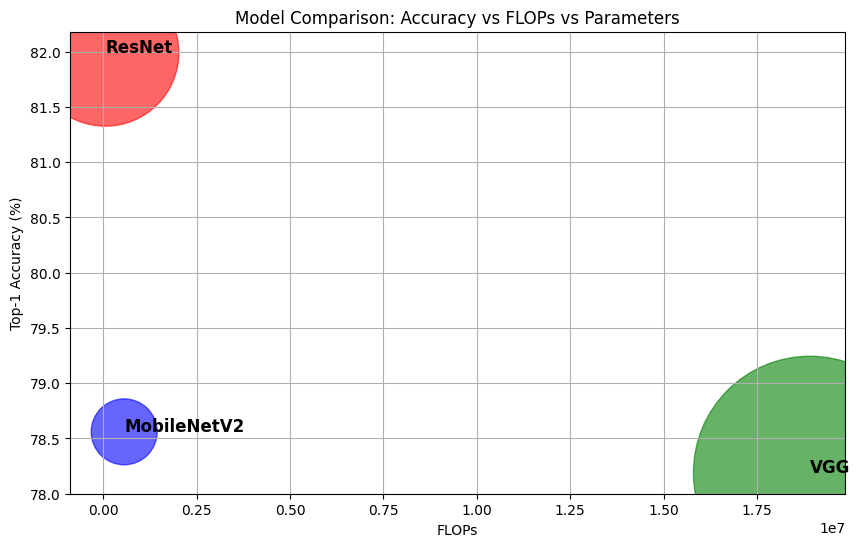

In [ ]:
import matplotlib.pyplot as plt


flops = [flops_mobilenet, flops_vgg, flops_resnet]
accuracies = [mobilenet_accuracy, vggnet_accuracy, resnet_accuracy]
params = [params_mobilenet, params_vgg, params_resnet]
model_names = ['MobileNetV2', 'VGG', 'ResNet']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(flops, accuracies, s=[p / 1e3 for p in params], c=['blue', 'green', 'red'], alpha=0.6)
plt.xlabel('FLOPs')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Model Comparison: Accuracy vs FLOPs vs Parameters')

for i, model_name in enumerate(model_names):
    plt.annotate(model_name, (flops[i], accuracies[i]), fontsize=12, weight='bold')

plt.grid(True)
plt.show()
